<a href="https://colab.research.google.com/github/ale-camer/Data-Analysis/blob/Finance/Argentina_Macroeconom%C3%ADa_y_empleo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Argentina. Macroeconomía y empleo.

En esta NoteBook se pretende ilustrar en cuatro simples gráficos los problemas macroeconómicos de Argentina y cómo eso afecta al empleo en materia de precio (sueldo) y cantidad.

In [ ]:
# librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as dates
from prettytable import PrettyTable
import warnings
warnings.filterwarnings("ignore")

A los fines de poder llevar a cabo los análisis correspondientes, los datos fueron descargados manualmente y se pueden encontrar en el siguiente [link](https://github.com/ale-camer/Data-Base/blob/Finance/Argentina.%20Macroeconom%C3%ADa%20y%20empleo.%20Datos.zip). Se procedió de esta forma debido a que a algunas de las rutas no se puede acceder directamente desde Python. Por ende, si se desea realizar lo propio desde distintos mecanismos al pie de los siguientes links se encontrarán los hipervínculos que hay en cada uno de ellos a partir de los cuales se descargan los datos. A si mismo, en el anexo, al final del código, se encontrará la parte del código de preprocesamiento a realizar si se obtienen los datos puros. 

Links:
- https://data.worldbank.org/indicator/NY.GDP.DEFL.KD.ZG?locations=AR (1)
- https://data.worldbank.org/indicator/NY.GDP.MKTP.KD.ZG?locations=AR (2)
- https://www.argentina.gob.ar/economia/politicaeconomica/macroeconomica/gastopublicoconsolidado (3)
- https://www.trabajo.gov.ar/downloads/estadisticas/trabajoregistrado/trabajoregistrado_2203_estadisticas.xlsx
- https://datos.gob.ar/ar/dataset/sspm-asalariados-registrados-sector-privado-por-provincia/archivo/sspm_154.1 (5)
- https://www.indec.gob.ar/indec/web/Nivel4-Tema-4-31-61 (6)
- https://www.indec.gob.ar/indec/web/Nivel4-Tema-3-9-48 (7)



1. CSV
2. CSV
3. Gasto público consolidado
5. DESCARGAR (fondo verde y letras blancas en mayúscula)
6. Índice de salarios. Números índices y variaciones porcentuales respecto del período anterior y acumuladas, por sector. Octubre de 2015-abril de 2022
7. Índice de salarios, valores al último día de cada mes, desde octubre de 2001 en adelante (empalme de la serie base cuarto trimestre de 2001=100 con la serie base abril de 2012=100)

In [ ]:
# data
gp1980 = pd.read_csv("/content/gastoPublico.txt",sep='\t')
pbiHist = pd.read_csv("/content/pbiCrec.txt",sep='\t')
infHist = pd.read_csv("/content/inflacion.txt",sep='\t')
trabajo2012 = pd.read_csv("/content/tipoEmpleo.txt",sep='\t')
trabajo2009 = pd.read_csv("/content/empleoProv.txt",sep='\t')
EMAE2004 = pd.read_csv("/content/EMAE.txt",sep='\t')
salDesde2015 = pd.read_csv("/content/salDesde2015.txt",sep='\t')
salHasta2015 = pd.read_csv("/content/salHasta2015.txt",sep='\t')

## Preprocesamiento

In [ ]:
trabajo2012.drop('Período',axis=1,inplace=True)
trabajo2012.columns = ['Empleo privado','Empleo público','Empleo en casas particulares','Autónomos','Monotributo','Monotributo Social','Total']
trabajo2012.index = pd.date_range(start='01-01-2012',end='04-01-2022',freq='M').strftime('%Y-%m')
for col in trabajo2012.columns:
  if trabajo2012[col].dtype == 'O':
     trabajo2012[col] = trabajo2012[col].str.replace(',','')
     trabajo2012[col] = trabajo2012[col].astype('float')
  else:
    continue
trabajo2012.index = pd.to_datetime(trabajo2012.index)

pob2010, pob2022 = 40117096, 47327407
crecAnual = (pob2022/pob2010)**(1/(2022-2010))-1
crecPob = round((pob2022/(pob2010*(1+crecAnual)**2)-1)*100,2)

trabajo2009['total'] = trabajo2009.sum(axis=1)
trabajo2009.index = pd.date_range(start='01-01-2009',end='04-01-2022',freq='M').strftime('%Y-%m')
trabajo2009.drop('indice_tiempo',axis=1,inplace=True)

first, last = EMAE2004.columns, EMAE2004.iloc[-1,0]
EMAE2004.iloc[1:,0] = EMAE2004.iloc[0:-1,0]
EMAE2004.iloc[0,0] = first
EMAE2004.columns = ['gdp']
EMAE2004 = EMAE2004.append(pd.DataFrame([last], columns = ['gdp']))
EMAE2004.index = pd.date_range(start='01-01-2004',end='04-01-2022',freq='M').strftime('%Y-%m')

gp1980 = gp1980.T.rename(columns={0:'pubExpToGDP'})
gp1980.index = gp1980.index.str.replace('*','')

pbiHist = pbiHist.T.rename(columns={0:'gdpGrowth'})

infHist = infHist.T.rename(columns={0:'inflation'})

gpVsGdp = gp1980.merge(pbiHist,left_index=True,right_index=True,how='left').merge(infHist,left_index=True,right_index=True,how='left')
gpVsGdp.index = gpVsGdp.index.astype('int')

gdpJobs = pd.DataFrame(trabajo2009['total']).merge(pd.DataFrame(EMAE2004['gdp']),left_index=True,right_index=True,how='left')
gdpJobs.index = pd.to_datetime(gdpJobs.index)
corr1 = round(np.corrcoef(gdpJobs.iloc[:,0].astype('float'),gdpJobs.iloc[:,1].astype('float'))[0][1]*100,2)

first1, first2, last1, last2 = salHasta2015.columns[0], salHasta2015.columns[1], salHasta2015.iloc[-1,0], salHasta2015.iloc[-1,1]
salHasta2015.iloc[1:,0], salHasta2015.iloc[1:,1] = salHasta2015.iloc[0:-1,0], salHasta2015.iloc[0:-1,1]
salHasta2015.iloc[0,0], salHasta2015.iloc[0,1] = first1, first2
salHasta2015.columns = ['sectorPrivado','sectorPublibo']
salHasta2015 = salHasta2015.append(pd.DataFrame([last1, last2]).T.rename(columns={0:'sectorPrivado',1:'sectorPublibo'}),ignore_index=True)
salHasta2015.index = pd.date_range(start='10-01-2001',end='11-01-2015',freq='M').strftime('%Y-%m')

first3, first4, last3, last4 = salDesde2015.columns[0], salDesde2015.columns[1], salDesde2015.iloc[-1,0], salDesde2015.iloc[-1,1]
salDesde2015.iloc[1:,0], salDesde2015.iloc[1:,1] = salDesde2015.iloc[0:-1,0], salDesde2015.iloc[0:-1,1]
salDesde2015.iloc[0,0], salDesde2015.iloc[0,1] = first3, first4
salDesde2015.columns = ['sectorPrivado','sectorPublibo']
salDesde2015 = salDesde2015.append(pd.DataFrame([last3, last4]).T.rename(columns={0:'sectorPrivado',1:'sectorPublibo'}),ignore_index=True)
salDesde2015.index = pd.date_range(start='10-01-2015',end='04-01-2022',freq='M').strftime('%Y-%m')
salDesde2015

salarios = pd.concat([
                      pd.concat([salHasta2015['sectorPrivado'],salHasta2015['sectorPrivado'][-1] * (1+salDesde2015['sectorPrivado'].astype('float').pct_change().cumsum().dropna())]),
                      pd.concat([salHasta2015['sectorPublibo'],salHasta2015['sectorPublibo'][-1] * (1+salDesde2015['sectorPublibo'].astype('float').pct_change().cumsum().dropna())])],axis=1)

salariosLista = []
for i in np.arange(0,salarios.shape[0]+1,12):
  if i < 240:
    salariosLista.append((salarios.iloc[2+i+12,0]/salarios.iloc[2+i,0]-1))
  else:
    salariosLista.append((salarios.iloc[2+i,0]/salarios.iloc[2+i,0]-1))
salariosLista = pd.DataFrame(salariosLista[:-1]).rename(columns={0:'crecSal'})
salariosLista.index = np.arange(2002,2022,1)
infHist.index = infHist.index.astype('int')

salReal = salariosLista.merge(infHist,left_index=True,right_index=True,how='left')
salReal.loc[2021,'inflation'] = 50.9
salReal['inflation'] = salReal['inflation']/100
salReal = (1+salReal.cumsum())*100
salReal['salReal'] = (1 + salReal['crecSal']) / (1 + salReal['inflation']) - 1

row1st = []
row1st.insert(0,{'crecSal':100,'inflation':100,'salReal':0})
salReal = pd.concat([pd.DataFrame(row1st),salReal])
salReal.index = np.arange(2001,2022,1)
salReal.index = pd.to_datetime(salReal.index,format='%Y')
pbiHist.index = pd.to_datetime(pbiHist.index.astype('int'),format='%Y')
salReal = salReal.merge(pbiHist,left_index=True,right_index=True,how='left')
salReal.loc['2021-01-01','gdpGrowth'] = 10.3
salReal['gdpGrowth'] = salReal['gdpGrowth'].cumsum()

lala = trabajo2012.copy()
cols = {}
for col in lala.columns:
  # print(lala[col] / lala['Total'])
  cols[f'{col}'] = lala[col] / lala['Total']
cols = pd.DataFrame(cols)
cols.drop('Total',axis=1,inplace=True)

## Política económica y crecimiento

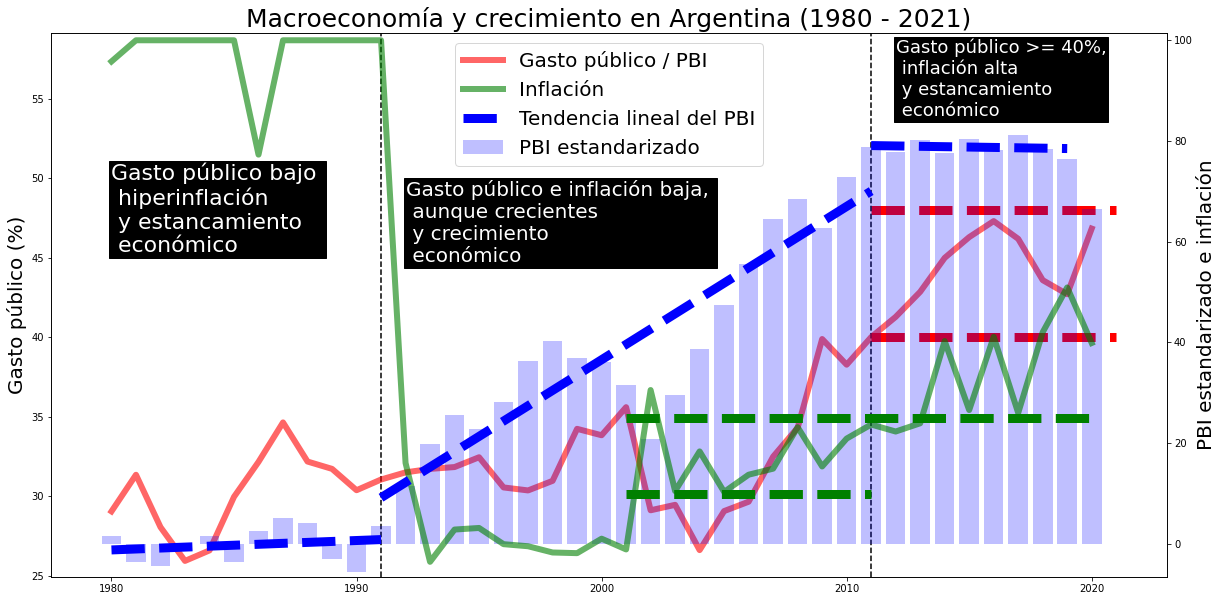

In [ ]:
serie1, serie2, serie3 = gpVsGdp.loc[:,'pubExpToGDP'], gpVsGdp.loc[:,'gdpGrowth'].cumsum(), gpVsGdp.loc[:,'inflation']
desde1, desde2, desde3, hasta1, hasta2, hasta3, line, marker, marketType = 0, 11, 31, 12, 32, 40, 6, 9, 'dashed'
z1, z2, z3 = np.polyfit(x = serie2.index[desde1:hasta1].astype('float'), y = serie2.iloc[desde1:hasta1].astype('float'), deg = 1), \
  np.polyfit(x = serie2.index[desde2:hasta2].astype('float'), y = serie2.iloc[desde2:hasta2].astype('float'), deg = 1), \
    np.polyfit(x = serie2.index[desde3:hasta3].astype('float'), y = serie2.iloc[desde3:hasta3].astype('float'), deg = 1)
p1, p2, p3 = np.poly1d(z1), np.poly1d(z2), np.poly1d(z3)

fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1.twinx()
ax1.plot(gpVsGdp.index, serie1, color='r', linewidth = line, label = 'Gasto público / PBI', alpha=.6)
ax2.bar(gpVsGdp.index, serie2, color='b', alpha = 0.25, label = 'PBI estandarizado')
ax2.plot(gpVsGdp.index, np.where(serie3 >= 100, 100, serie3), color='g', linewidth = line, label = 'Inflación', alpha=.6)
ax2.plot(gpVsGdp.index[desde1:hasta1], p1(gpVsGdp.index[desde1:hasta1].astype('float')), color='b', linewidth = marker, linestyle = marketType, label = 'Tendencia lineal del PBI')
ax2.plot(gpVsGdp.index[desde2:hasta2], p2(gpVsGdp.index[desde2:hasta2].astype('float')), color='b', linewidth = marker, linestyle = marketType)
ax2.plot(gpVsGdp.index[desde3:hasta3], p3(gpVsGdp.index[desde3:hasta3].astype('float')), color='b', linewidth = marker, linestyle = marketType)

ax1.hlines(y=40,xmin=2011,xmax=2021,color='red',linestyles=marketType,linewidth=marker)
ax1.hlines(y=48,xmin=2011,xmax=2021,color='red',linestyles=marketType,linewidth=marker)
ax2.hlines(y=25,xmin=2001,xmax=2020,color='green',linestyles=marketType,linewidth=marker)
ax2.hlines(y=10,xmin=2001,xmax=2011,color='green',linestyles=marketType,linewidth=marker)
ax1.vlines(x=1991,ymin=serie1.min()-1,ymax=serie1.max()*1.25,color='black',linestyles=marketType)
ax1.vlines(x=2011,ymin=serie1.min()-1,ymax=serie1.max()*1.25,color='black',linestyles=marketType)

ax2.text(1980,58,'Gasto público bajo \n hiperinflación \n y estancamiento \n económico',color='white',
         bbox=dict(facecolor='black',edgecolor='black',pad=2.0),fontsize=22)
ax2.text(1992,56,'Gasto público e inflación baja, \n aunque crecientes \n y crecimiento \n económico',color='white',
         bbox=dict(facecolor='black',edgecolor='black',pad=2.0),fontsize=20)
ax2.text(2012,85,'Gasto público >= 40%,\n inflación alta\n y estancamiento \n económico',color='white',
         bbox=dict(facecolor='black',edgecolor='black',pad=2.0),fontsize=18)

ax1.set_ylim(ymin=serie1.min()-1,ymax=serie1.max()*1.25)
ax2.set_ylim(ymin=serie2.min()-1,ymax=serie2.max()*1.25)
ax1.set_ylabel('Gasto público (%)',fontsize=20)
ax2.set_ylabel('PBI estandarizado e inflación',fontsize=20)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines, labels = lines_1 + lines_2, labels_1 + labels_2
ax1.legend(lines, labels, loc='upper center', fontsize=20)

plt.title('Macroeconomía y crecimiento en Argentina (1980 - 2021)',fontsize=25)
plt.show()

Lo primero que se debe aclarar es que la serie que esplica la inflación en los años en que la misma supera el valor de 100 se le asigna dicho valor para un mejor entendimiento de la misma. También cabe aclarar que las líneas horizontales verdes y rojas buscan resaltar los niveles de inflación y gasto público sobre el PBI en determinados periodos.

También es importante contar que este gráfico se circunscribe en el contexto en que la economía Argentina desde 1880 hasta las actualidad en las únicas décadas en las que no presentó crecimiento económico, sino que estancamiento, fueron en las décadas de 1980-1989 y 2010-2019 si consideramos las mismas con múltiplos de 10.

La política económica de todo gobierno tiene dos partes: la fiscal y la monetaria. En la primera se decide cuánto se va a gastar y se estima cuánto se va a recaudar en cada periodo fiscal, y en la segunda se busca, a través de la institución de una autoridad monetaria independiente del gobierno (llamado Banco Central en la mayoría de los países del mundo), la estabilidad monetaria.

En materia fiscal cuanto menor sea el gasto del sector público menores recursos necesitará recaudar y, por ende, mayor cantidad de recursos disponibles tendrá el sector privado para ampliar su capacidad productiva. En materia monetaria todos los bancos centrales buscan el equilibrio entre la oferta y la demanda monetaria para que no hayan cambios en los niveles precios (inflación) que complejicen la operatoria cotidiana de los distintos agentes que la componen.

Este gráfico explica cómo durante la década de 1980-1989, a pesar de tener un gasto público bajo, los niveles sumamente altos de inflación no permitieron el desarrollo normal de la economía ahogándola en un estancamiento hasta llevarla en la mayor crisis económica de su historia hasta ese moemnto que fueron las hiperinflaciones de los añosd 1989 y 1990 en donde la inflación anual alcanzó los cuatro dígitos en ambos años.

Posterior a esto, se siguió manteniendo un gasto público bajo y se implementó en esquema convertibilidad monetaria que eliminó la inflación y permitió el crecimiento sostenido de la economía, salvo por el año 2002 en el que país vivió su peor crisis económica debido al creciente gasto público y consecuente acumulación de deuda que no pudo ser honrada debidamente, pero que gracias a las políticas que se venían manteniendo, a un fuerte ajuste que se hizo del gasto público en el año 2002 y el crecimiento de los precios de las materias primas el país se recuperó rápido y creció durante el resto de la década 2000-2009 a expensas de un crecimiento constante y sostenido de la inflación y el gasto público que desde el año 2012 hasta la fecha no permitieron qeu el país vuelva a crecer y del que no se prevee horizonte alguno para que se recupere el crecimiento.

## Empleo (Cantidad)

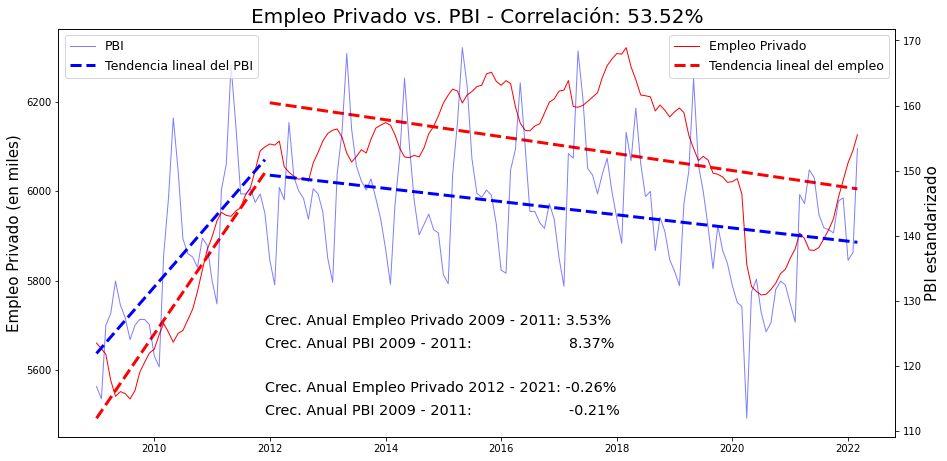

In [ ]:
a, b, c, d = (gdpJobs.loc['2011-01-01':'2011-12-01','total'].mean() / gdpJobs.loc['2009-01-01':'2009-12-01','total'].mean() - 1) / (2011-2009), \
  (gdpJobs.loc['2021-01-01':'2021-12-01','total'].mean() / gdpJobs.loc['2012-01-01':'2012-12-01','total'].mean() - 1) / (2021-2011), \
    (gdpJobs.loc['2011-01-01':'2011-12-01','gdp'].mean() / gdpJobs.loc['2009-01-01':'2009-12-01','gdp'].mean() - 1) / (2011-2009), \
      (gdpJobs.loc['2021-01-01':'2021-12-01','gdp'].mean() / gdpJobs.loc['2012-01-01':'2012-12-01','gdp'].mean() - 1) / (2021-2011)
dates1, dates2 = gdpJobs.loc['2009-01-01':'2011-12-01'].index, gdpJobs.loc['2012-01-01':'2022-03-01'].index
x_num1, x_num2 = dates.date2num(dates1), dates.date2num(dates2)
z1, z2, z3, z4 = np.polyfit(x = x_num1, y = gdpJobs.loc['2009-01-01':'2011-12-01','total'].values.astype('float'), deg = 1), \
  np.polyfit(x = x_num2, y = gdpJobs.loc['2012-01-01':'2022-12-01','total'].values.astype('float'), deg = 1), \
    np.polyfit(x = x_num1, y = gdpJobs.loc['2009-01-01':'2011-12-01','gdp'].values.astype('float'), deg = 1), \
      np.polyfit(x = x_num2, y = gdpJobs.loc['2012-01-01':'2022-12-01','gdp'].values.astype('float'), deg = 1)
p1, p2, p3, p4 = np.poly1d(z1), np.poly1d(z2), np.poly1d(z3), np.poly1d(z4)
x_fit1, x_fit2 = np.linspace(x_num1.min(), x_num1.max()), np.linspace(x_num2.min(), x_num2.max())

fig, ax1 = plt.subplots(figsize=(15,7.5))
ax2 = ax1.twinx()
ax1.plot(gdpJobs.index, gdpJobs.iloc[:,0], c='r', label = 'Empleo Privado',linewidth=1)
ax1.plot(dates.num2date(x_fit1), p1(x_fit1), c='r', label = 'Tendencia lineal del empleo',linewidth=3,linestyle=marketType)
ax1.plot(dates.num2date(x_fit2), p2(x_fit2), c='r',linewidth=3,linestyle=marketType)
ax2.plot(gdpJobs.index, gdpJobs.iloc[:,1], c='b', alpha = 0.5, label = 'PBI',linewidth=1)
ax2.plot(dates.num2date(x_fit1), p3(x_fit1), c='b', label = 'Tendencia lineal del PBI',linewidth=3,linestyle=marketType)
ax2.plot(dates.num2date(x_fit2), p4(x_fit2), c='b',linewidth=3,linestyle=marketType)

ax1.text(x_fit1[-1],5700,f'Crec. Anual Empleo Privado 2009 - 2011: {round(a*100,2)}%',fontsize='x-large')
ax1.text(x_fit1[-1],5650,f'Crec. Anual PBI 2009 - 2011:                     {round(c*100,2)}%',fontsize='x-large')
ax1.text(x_fit1[-1],5550,f'Crec. Anual Empleo Privado 2012 - 2021: {round(b*100,2)}%',fontsize='x-large')
ax1.text(x_fit1[-1],5500,f'Crec. Anual PBI 2009 - 2011:                     {round(d*100,2)}%',fontsize='x-large')

ax1.set_ylabel('Empleo Privado (en miles)',fontsize=15)
ax2.set_ylabel('PBI estandarizado',fontsize=15)
ax1.legend(loc='upper right',fontsize=12.5)
ax2.legend(loc='upper left',fontsize=12.5)
plt.title(f'Empleo Privado vs. PBI - Correlación: {corr1}%',fontsize=20)
plt.show()

Este gráfico nos muestra el efecto directo que tiene la falta de crecimiento económico sobre el empleo. Es importante resaltar especialmente el efecto sobre el empleo privado porque es aquél que financia el gasto publico y representa la mayor proporción de los distintos tipos de empleo (ver próximo gráfico).

Acá claramente podemos apreciar cómo durante el periodo 2009-2011 el crecimiento económico permitía la generación de empleo privado y que posteriormente a ello hasta la actualidad la economía y el empleo privado se encuentran estancados. Esto tiene como consecuencia una degradación de la calidad del empleo ya que este no acompaña el crecimiento demográfico lo que tiene como consecuencia que la parte de la población que no se pueda incorporar a la economía formal o sean reemplazados dentro de la misma, o bien degraden su calidad de empleo, deban incurrir a la informalidad, al auxilio del estado o a una combinación de las mismas para cubrir sus necesidades básicas.  

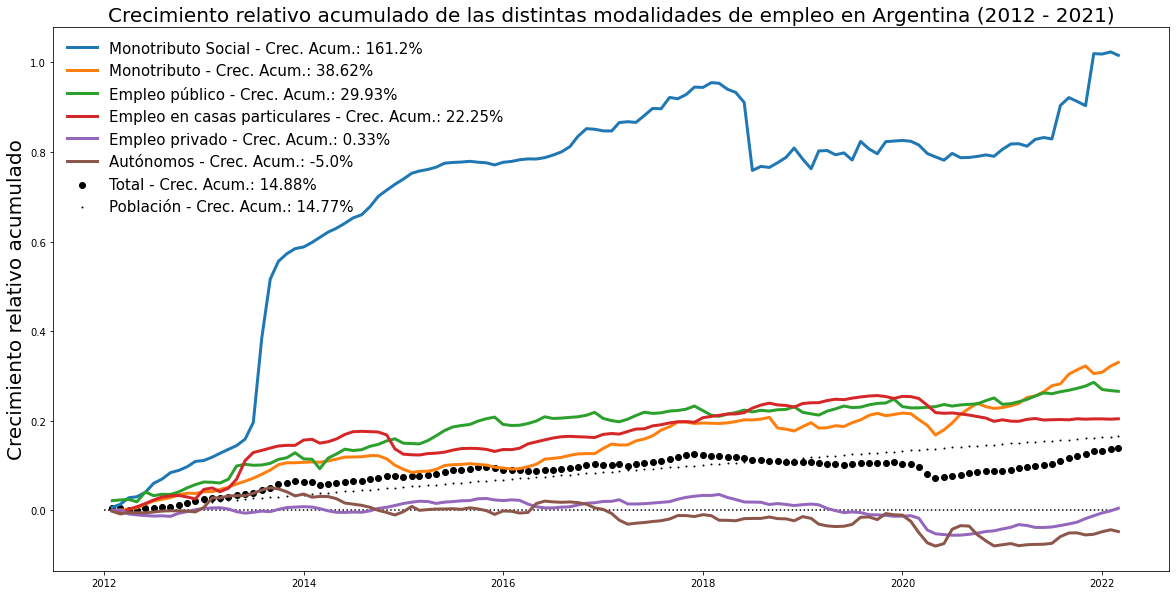

+-------------------------------------------------------+
| Proporción de empleados por tipo de empleo en 01-2012 |
+---------------------------------------+---------------+
|             Tipo de empleo            |   Proporción  |
+---------------------------------------+---------------+
|             Empleo privado            |     55.86     |
|             Empleo público            |     23.27     |
|              Monotributo              |     12.03     |
|               Autónomos               |      3.75     |
|      Empleo en casas particulares     |      3.56     |
|           Monotributo Social          |      1.54     |
+---------------------------------------+---------------+ 
 +-------------------------------------------------------+
| Proporción de empleados por tipo de empleo en 03-2022 |
+---------------------------------------+---------------+
|             Tipo de empleo            |   Proporción  |
+---------------------------------------+---------------+
|           

In [ ]:
firstRow, lastRow = trabajo2012.index[0], trabajo2012.index[-1]
a, b, c, d, e, f, g = round((trabajo2012.loc[lastRow,'Empleo privado'] / trabajo2012.loc[firstRow,'Empleo privado'] - 1)*100,2), round((trabajo2012.loc[lastRow,'Empleo público'] / trabajo2012.loc[firstRow,'Empleo público'] - 1)*100,2), \
  round((trabajo2012.loc[lastRow,'Empleo en casas particulares'] / trabajo2012.loc[firstRow,'Empleo en casas particulares'] - 1)*100,2), round((trabajo2012.loc[lastRow,'Autónomos'] / trabajo2012.loc[firstRow,'Autónomos'] - 1)*100,2), \
    round((trabajo2012.loc[lastRow,'Monotributo'] / trabajo2012.loc[firstRow,'Monotributo'] - 1)*100,2), round((trabajo2012.loc[lastRow,'Monotributo Social'] / trabajo2012.loc[firstRow,'Monotributo Social'] - 1)*100,2), \
      round((trabajo2012.loc[lastRow,'Total'] / trabajo2012.loc[firstRow,'Total'] - 1)*100,2)

plt.figure(figsize=(20,10))
plt.plot(pd.to_datetime(trabajo2012.index), trabajo2012['Monotributo Social'].pct_change().cumsum(), label = f'Monotributo Social - Crec. Acum.: {f}%', linewidth = 3)
plt.plot(pd.to_datetime(trabajo2012.index), trabajo2012['Monotributo'].pct_change().cumsum(), label = f'Monotributo - Crec. Acum.: {e}%', linewidth = 3)
plt.plot(pd.to_datetime(trabajo2012.index), trabajo2012['Empleo público'].pct_change().cumsum(), label = f'Empleo público - Crec. Acum.: {b}%', linewidth = 3)
plt.plot(pd.to_datetime(trabajo2012.index), trabajo2012['Empleo en casas particulares'].pct_change().cumsum(), label = f'Empleo en casas particulares - Crec. Acum.: {c}%', linewidth = 3)
plt.plot(pd.to_datetime(trabajo2012.index), trabajo2012['Empleo privado'].pct_change().cumsum(), label = f'Empleo privado - Crec. Acum.: {a}%', linewidth = 3)
plt.plot(pd.to_datetime(trabajo2012.index), trabajo2012['Autónomos'].pct_change().cumsum(), label = f'Autónomos - Crec. Acum.: {d}%', linewidth = 3)
plt.scatter(pd.to_datetime(trabajo2012.index), trabajo2012['Total'].pct_change().cumsum(), label = f'Total - Crec. Acum.: {g}%', color = 'black')
plt.scatter(pd.to_datetime(trabajo2012.index), pd.Series(np.linspace(pob2010, pob2022, len(trabajo2012.index))).pct_change().cumsum(), label = f'Población - Crec. Acum.: {crecPob}%', color = 'black', s = 1)
plt.hlines(y=0,xmin=trabajo2012.index[0],xmax=trabajo2012.index[-1],linestyles='dotted',color='black')
plt.legend(loc='upper left',frameon=False,fontsize=15)
plt.ylabel("Crecimiento relativo acumulado",fontsize=20)
plt.title('Crecimiento relativo acumulado de las distintas modalidades de empleo en Argentina (2012 - 2021)',fontsize=20)
plt.show()

x, y = PrettyTable(), PrettyTable()
x.title, y.title = 'Proporción de empleados por tipo de empleo en 01-2012', 'Proporción de empleados por tipo de empleo en 03-2022'
x.field_names, y.field_names = ["Tipo de empleo", "Proporción"], ["Tipo de empleo", "Proporción"]
for i in range(cols.shape[1]):
  x.add_row([cols.columns[i],round(cols.iloc[0,i]*100,2)])
  y.add_row([cols.columns[i],round(cols.iloc[-1,i]*100,2)])
x.sortby, y.sortby = 'Proporción', 'Proporción'
x.reversesort, y.reversesort = True, True
print(x,'\n',y)

La primera reflexión que nos brinda este gráfico es que el empleo acompañó el crecimiento demográfico pero a expensas de una reducción en su calidad. En argentina existen distintas figuras legales para categorizar a la fuerza laboral. A los conocidos empleados públicos y privados en relación de dependencia, se le suman las siguiente categorías:


1.   Autónomo: empleado independendiente de mayor capacidad de ingresos.
2.   Monotributista: empleado independiente de menor capacidad de ingresos que un aotónomo.
1.   Monotributista social: monotributista que se encuentra dentro de las categorías del monotributo que menor capacidad de ingresos tiene.
2.   Empleo en casas particulares: son todos aquellos que realizan tareas domésticas.

Una segunda lectura y más importante lectura es que el crecimiento del empleo privado y de los autónomos fue nulo. El empleo privado es aquél que mayor valor genera de todos y los trabajadores autónomos representan a las futuras empresas que puede tener el país.

A expensas de esto tanto los monotributistas, empleados públicos y empleados domésticos crecieron en promedio un 30% em este periodo y los monotributistas sociales, que son aquellos trabajadores que menor valor aportan a la economía, crecieron alrededor del 160&.

Esto permite concluir en que hubo una clara caída en la calidad de vida de los argentinos durante el periodo en cuestión.





## Empleo (Precio)

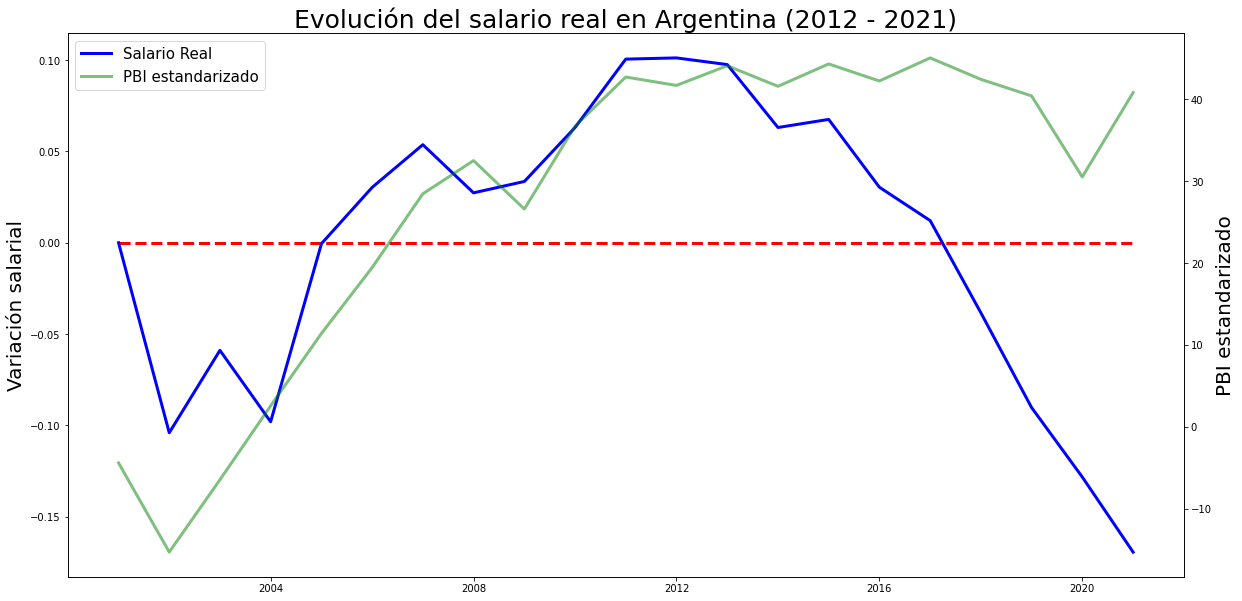

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1.twinx()
ax1.plot(salReal.index,salReal['salReal'],color='b',label='Salario Real',linewidth=3)
ax2.plot(salReal.index,salReal['gdpGrowth'],color='g',label='PBI estandarizado',alpha=0.5,linewidth=3)
ax1.hlines(y=0,xmin=salReal.index[0],xmax=salReal.index[-1],colors='r',linewidth=3,linestyles='dashed')
ax1.set_ylabel("Variación salarial",fontsize=20)
ax2.set_ylabel("PBI estandarizado",fontsize=20)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines, labels = lines_1 + lines_2, labels_1 + labels_2
ax1.legend(lines, labels, loc='upper left', fontsize=15)

plt.title("Evolución del salario real en Argentina (2012 - 2021)", fontsize=25)
plt.show()

Para finalizar, a la hora de estudiar la evolución del precio del empleo, o sea el salario, podemos ver que la capacidad de compra de los trabajadores crece si y solo si la economía crece de forma sostenida, ya que cuando esta cae o se estanca el poder de compra cae continuamente y este tarda en recuperarase.

Lo más importante es resaltar que al problema del estancamiento económico ya mencionado en repetidas oportunidades, desde el año 2018 la economía argentina se encuentra en caída libre y así lo hace también la calidad de vida de sus habitantes. Esto quiere decir que la economía ya no se encuentra estancada sino que se encuentra en decrecimiento por lo que volver a estancarse podría considerarse un primer síntoma de recuperación. 

## Anexo

In [ ]:
# data
"""
trabajo2012 = pd.read_excel("https://www.trabajo.gob.ar/downloads/estadisticas/trabajoregistrado/trabajoregistrado_2203_estadisticas.xlsx",sheet_name="T.2.1")
trabajo2009 = pd.read_csv("https://infra.datos.gob.ar/catalog/sspm/dataset/154.1/download/asalariados-registrados-sector-privado-segun-provincia-datos-con-estacionalidad.csv",index_col=[0])
EMAE2004 = pd.read_excel("https://www.indec.gob.ar/ftp/cuadros/economia/sh_emae_mensual_base2004.xls")
salDesde2015 = pd.read_excel("https://www.indec.gob.ar/ftp/cuadros/sociedad/variaciones_salarios_05_22.xls",sheet_name="Cuadro 1")
salHasta2015 = pd.read_excel("https://www.indec.gob.ar/ftp/cuadros/sociedad/serie_is_2012.xls",sheet_name="Serie histórica IS")

gp1980 = pd.read_excel("C:/Useres/XXX/Desktop/gasto_publico_consolidado_1980-2020.xls",sheet_name="% del PIB",index_col=[0])
pbiHist = pd.read_excel("C:/Useres/XXX/Desktop/trabajoregistrado_2203_estadisticas.xlsx",sheet_name="Data",index_col=[0])
infHist = pd.read_excel("C:/Useres/XXX/Desktop/trabajoregistrado_2203_estadisticas.xlsx",sheet_name="Data",index_col=[0])

# preprocesamiento
trabajo2012.columns = trabajo2012.iloc[0,:]
trabajo2012.set_index('Período',inplace=True)
trabajo2012 = trabajo2012.iloc[:,:-1]
trabajo2012 = trabajo2012.iloc[1:,:]
trabajo2012.dropna(inplace=True)
trabajo2012.columns = ['Empleo privado','Empleo público','Empleo en casas particulares','Autónomos','Monotributo','Monotributo Social','Total']
trabajo2012.index = pd.date_range(start='01-01-2012', end='04-01-2022', freq='M').strftime('%Y-%m')
trabajo2012.index = pd.to_datetime(trabajo2012.index)

trabajo2009['total'] = trabajo2009.sum(axis=1)
trabajo2009.index = pd.to_datetime(trabajo2009.index).strftime('%Y-%m')

EMAE2004 = pd.concat([pd.DataFrame(pd.date_range(start='01-01-2004', end='04-01-2022', freq='M')),EMAE2004.iloc[3:-2,2],EMAE2004.iloc[3:-2,4]],axis=1)
EMAE2004.iloc[3:,0] = EMAE2004.iloc[0:-3,0]
EMAE2004 = EMAE2004.iloc[3:,:]
EMAE2004.columns = ['period','gdp','seasonalGdp']
EMAE2004.set_index('period',inplace=True)
EMAE2004.index = EMAE2004.index.strftime('%Y-%m')

gp1980.dropna(inplace=True)
gp1980 = gp1980.iloc[:2,1:].T
gp1980.columns = ['year','pubExpToGDP']
gp1980.index = np.concatenate([gp1980['year'][:4].values, gp1980['year'].str.replace('*','').dropna().values]).astype('int')
gp1980.drop('year',axis=1,inplace=True)

pbiHist.drop(['Unnamed: 4','Unnamed: 65'],axis=1,inplace=True)
pbiHist = pbiHist.loc[['Country Name','Argentina'],:].T.iloc[3:,:].rename(columns={'Country Name':'year','Argentina':'gdpGrowth'}).set_index('year')

infHist.drop(['Unnamed: 4','Unnamed: 65'],axis=1,inplace=True)
infHist = infHist.loc[['Country Name','Argentina'],:].T.iloc[3:,:].rename(columns={'Country Name':'year','Argentina':'inflation'}).set_index('year')

gpVsGdp = gp1980.merge(pbiHist,left_index=True,right_index=True,how='left').merge(infHist,left_index=True,right_index=True,how='left')
gpVsGdp.index = gpVsGdp.index.astype('int')

gdpJobs = pd.DataFrame(trabajo2009['total']).merge(pd.DataFrame(EMAE2004['gdp']),left_index=True,right_index=True,how='left')
gdpJobs.index = pd.to_datetime(gdpJobs.index)
corr1 = round(np.corrcoef(gdpJobs.iloc[:,0].astype('float'),gdpJobs.iloc[:,1].astype('float'))[0][1]*100,2)

salHasta2015 = pd.concat([salHasta2015.iloc[:,1], salHasta2015.iloc[:,3]],axis=1).dropna().iloc[1:,:]
salHasta2015.columns = ['sectorPrivado','sectorPublibo']
salHasta2015.index = pd.date_range(start='2001-10-01',end='2015-11-01',freq='M')
salDesde2015 = pd.concat([salDesde2015.iloc[:,3], salDesde2015.iloc[:,5]],axis=1).dropna().iloc[1:,:]
salDesde2015.columns = ['sectorPrivado','sectorPublibo']
salDesde2015.index = pd.date_range(start='2015-10-01',end='2022-04-01',freq='M')

salarios = pd.concat([
                      pd.concat([salHasta2015['sectorPrivado'],salHasta2015['sectorPrivado'][-1] * (1+salDesde2015['sectorPrivado'].pct_change().cumsum().dropna())]),
                      pd.concat([salHasta2015['sectorPublibo'],salHasta2015['sectorPublibo'][-1] * (1+salDesde2015['sectorPublibo'].pct_change().cumsum().dropna())])],axis=1)

salariosLista = []
for i in np.arange(0,salarios.shape[0]+1,12):
  if i < 240:
    salariosLista.append((salarios.iloc[2+i+12,0]/salarios.iloc[2+i,0]-1))
  else:
    salariosLista.append((salarios.iloc[2+i,0]/salarios.iloc[2+i,0]-1))
salariosLista = pd.DataFrame(salariosLista[:-1]).rename(columns={0:'crecSal'})
salariosLista.index = np.arange(2002,2022,1)

salReal = salariosLista.merge(infHist,left_index=True,right_index=True,how='left')
salReal.loc[2021,'inflation'] = 50.9
salReal['inflation'] = salReal['inflation']/100
salReal = (1+salReal.cumsum())*100
salReal['salReal'] = (1 + salReal['crecSal']) / (1 + salReal['inflation']) - 1

row1st = []
row1st.insert(0,{'crecSal':100,'inflation':100,'salReal':0})
salReal = pd.concat([pd.DataFrame(row1st),salReal])
salReal.index = np.arange(2001,2022,1)
salReal.index = pd.to_datetime(salReal.index,format='%Y')
pbiHist.index = pd.to_datetime(pbiHist.index.astype('int'),format='%Y')
salReal = salReal.merge(pbiHist,left_index=True,right_index=True,how='left')
salReal.loc['2021-01-01','gdpGrowth'] = 10.3
salReal['gdpGrowth'] = salReal['gdpGrowth'].cumsum() 
"""